## API DOC WHAT I NEED

**General info**:
SUMMONER/V4
- Summoner name
- Summoner level 

**League**:
CHAMPION-MASTERY-V4
- Champ masteries level
- LastplayTime
LEAGUE/V4
- queueType
- tier
- rank
- leaguePoints
- wins
- losses
- inactive
MATCH/V5
- all match data

**What i want to visualize**:
- Win percentage overall and per role
- last 30 days/games wins/losses, y bar game time, the color of the bar red or green based on win or loss. Inside the bar the champ name you played that game, the x line the games and dates. A line trough the barplot indicating KDA
- last 30 days all played champs with their winrate and KDA
- Items the player build per champ over the last 30 days and the match outcome. To see what items and order worked best.
- Dynamic Itemization Analysis:
Analyze item builds dynamically based on the in-game situation. Show the player's most effective item builds against different team compositions or specific enemy champions.
- Teammate Synergy Radar Chart:
Create a radar chart that visualizes the synergy between the player and their most frequent teammates. Axes can represent metrics like win rate when playing together, average KDA in shared games, and objective control.
- Winning Conditions Radar Map:
Develop a radar map that outlines the key factors contributing to wins. Axes can represent objectives, vision control, kills, and other winning conditions, giving players insights into their strategic strengths.

Summoner name: Kiirbb
Summoner Level: 264
Stats for ranked_solo_duo:
Overall Win Percentage: 55.00%
Win Percentage for Top role: 0.00%
Number of games for Top role: 40
Win Percentage for Jungle role: 52.63%
Number of games for Jungle role: 41
Win Percentage for Middle role: 100.00%
Number of games for Middle role: 40
Win Percentage for Bottom role: 0.00%
Number of games for Bottom role: 40
Win Percentage for Utility role: 0.00%
Number of games for Utility role: 39


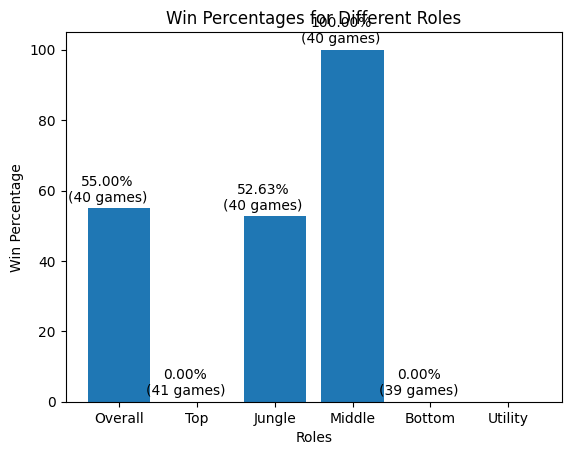

In [3]:
import requests
import matplotlib.pyplot as plt
import time
from lol_data import get_summoner_lol_data
from config import API_KEY

def get_match_ids(api_key, puuid, region, queue_type=None, start_time=None, end_time=None, count=20):
    region_mappings = {
        'na1': 'americas',
        'br1': 'americas',
        'lan': 'americas',
        'las': 'americas',
        'kr': 'asia',
        'jp': 'asia',
        'eune': 'europe',
        'euw1': 'europe',
        'tr1': 'europe',
        'ru': 'europe',
        'oce': 'sea',
        'ph2': 'sea',
        'sg2': 'sea',
        'th2': 'sea',
        'tw2': 'sea',
        'vn2': 'sea',
    }

    queue_type_mappings = {
        'ranked_solo_duo': 420,
        'ranked_flex': 440,
        'blind_pick': 430,
        'draft_pick': 400,
        'clash': 700
    }

    region = region.lower()
    routing_value = region_mappings.get(region, region)

    # Convert user-friendly queue type to numeric queue ID
    queue_id = queue_type_mappings.get(queue_type.lower())

    if queue_id is None:
        print("Invalid queue type. Please enter a valid queue type: ranked_solo_duo, ranked_flex, blind_pick, draft_pick, clash")
        return None

    matchlist_url = f'https://{routing_value}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids'
    headers = {'X-Riot-Token': api_key}

    params = {'startTime': start_time, 'endTime': end_time, 'count': count, 'queue': queue_id}

    try:
        response = requests.get(matchlist_url, headers=headers, params=params)

        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching match IDs: {response.status_code}, {response.text}")
            return None
    except Exception as e:
        print(f"Exception during match ID retrieval: {e}")
        return None

def get_match_data(api_key, match_id, region):
    routing_value = get_routing_value(region)

    match_url = f'https://{routing_value}.api.riotgames.com/lol/match/v5/matches/{match_id}'

    headers = {'X-Riot-Token': api_key}

    try:
        response = requests.get(match_url, headers=headers)

        if response.status_code == 200:
            match_data = response.json()
            # Voeg hier een controle toe voor het gametype
            if 'info' in match_data and 'gameMode' in match_data['info'] and match_data['info']['gameMode'].lower() == 'classic':
                return match_data
            else:
                print(f"Skipping match ID {match_id} as it is not a classic game.")
                return None
        else:
            print(f"Error fetching match data for match ID {match_id}: {response.status_code}, {response.text}")
            return None
    except Exception as e:
        print(f"Exception during match data retrieval: {e}")
        return None

def calculate_win_percentage_per_role(matches, summoner_puuid):
    total_matches = len(matches)

    valid_matches = [match for match in matches if match is not None]

    if valid_matches:
        overall_wins = 0
        overall_matches_with_wins = 0

        role_wins = {role: 0 for role in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]}
        role_matches_with_wins = {role: 0 for role in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]}
        role_total_matches = {role: 0 for role in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]}

        for match in valid_matches:
            if 'info' in match and 'participants' in match['info']:
                for participant in match['info']['participants']:
                    if 'individualPosition' in participant:
                        role = participant['individualPosition']
                        if role in role_wins:
                            if participant['puuid'] == summoner_puuid:
                                overall_matches_with_wins += 1
                                role_matches_with_wins[role] += 1
                                if participant.get('win', False):
                                    overall_wins += 1
                                    role_wins[role] += 1
                            role_total_matches[role] += 1

        overall_win_percentage = (overall_wins / overall_matches_with_wins) * 100 if overall_matches_with_wins > 0 else 0
        print(f"Overall Win Percentage: {overall_win_percentage:.2f}%")

        win_percentages = {"Overall": overall_win_percentage}

        for role in ["TOP", "JUNGLE", "MIDDLE", "BOTTOM", "UTILITY"]:
            role_win_percentage = (role_wins[role] / role_matches_with_wins[role]) * 100 if role_matches_with_wins[role] > 0 else 0
            print(f"Win Percentage for {role.capitalize()} role: {role_win_percentage:.2f}%")
            print(f"Number of games for {role.capitalize()} role: {role_total_matches[role]}")
            win_percentages[role.capitalize()] = role_win_percentage

        return win_percentages, role_total_matches
    else:
        print("No valid match data available.")

def get_routing_value(region):
    region_mappings = {
        'na1': 'americas',
        'br1': 'americas',
        'lan': 'americas',
        'las': 'americas',
        'kr': 'asia',
        'jp': 'asia',
        'eune': 'europe',
        'euw1': 'europe',
        'tr1': 'europe',
        'ru': 'europe',
        'oce': 'sea',
        'ph2': 'sea',
        'sg2': 'sea',
        'th2': 'sea',
        'tw2': 'sea',
        'vn2': 'sea',
    }

    return region_mappings.get(region.lower(), region.lower())

game_name = input("Enter Game Name (lol, tft, valorant): ").lower()
summoner_name = input("Enter Summoner Name: ")
region = input("Enter Region (e.g., na1, euw1): ")
queue_type = input("Enter Queue Type (e.g., ranked_solo_duo): ")

if game_name == 'lol':
    summoner_data = get_summoner_lol_data(API_KEY, summoner_name, region)
    if summoner_data:
        print(f"Summoner name: {summoner_data['name']}")
        print(f"Summoner Level: {summoner_data['summonerLevel']}")
        print(f"Stats for {queue_type}:")
        match_ids = get_match_ids(API_KEY, summoner_data['puuid'], region, queue_type)
        if match_ids:
            matches = []
            for match_id in match_ids:
                match_data = get_match_data(API_KEY, match_id, region)
                if match_data:
                    matches.append(match_data)
                else:
                    print(f"Error fetching match data for match ID {match_id}")
                time.sleep(1)

        win_percentages, role_total_matches = calculate_win_percentage_per_role(matches, summoner_data['puuid'])

        labels = list(win_percentages.keys())
        values = list(win_percentages.values())

        fig, ax = plt.subplots()
        bars = ax.bar(labels, values)
        plt.title('Win Percentages for Different Roles')
        plt.xlabel('Roles')
        plt.ylabel('Win Percentage')

        for bar, value, role in zip(bars, values, role_total_matches.keys()):
            plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 1,
                     f"{value:.2f}%\n({role_total_matches[role]} games)", ha='center', va='bottom')

        plt.show()
    else:
        print("No match data available for the summoner.")
else:
    print("Invalid game name.")